In [1]:
import seaborn as sns
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import pandas as pd
pd.options.mode.chained_assignment = None # supprime certains warnings
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import numpy as np

In [27]:

X = pd.read_csv("../Prix_metre/X_avec_prix.csv")
y_train = pd.read_csv("../y_train_OXxrJt1.csv")
X_test = pd.read_csv("../Prix_metre/X_test_avec_prix.csv")
X_train = pd.read_csv("../Prix_metre/X_train_avec_prix.csv")

annonces = X_test.id_annonce
y_train = y_train.drop(columns = ['id_annonce'])

## Feature Engineering

In [28]:
def features_incomplete(X):   
    Features_incomplete = []
    for x in X.columns:
        if X[x].isnull().sum()/len(X[x])*100 > 0:
            Features_incomplete.append(x)
    return Features_incomplete

def FE(X):
    X.drop(columns = ["exposition"],inplace=True)
    X.drop(columns=['ghg_category', 'energy_performance_category'], inplace=True)
    X['floor'].fillna(0, inplace=True)
    X['land_size'].fillna(0, inplace=True)

    #one hot encoding for property_type
    X = pd.get_dummies(X, columns=['property_type'], drop_first=True)

    # Label encoding for city
    le = LabelEncoder()
    X['city'] = le.fit_transform(X['city'])

    for x in features_incomplete(X):
    # On remplit les valeurs manquantes par la valeur la plus fréquente
        X[x].fillna(X[x].value_counts().index[0], inplace=True)
    
    X["Somme_bedrooms_rooms"] = X["nb_rooms"]+X["nb_bedrooms"]
    X["Somme_bathrooms_rooms"] = X["nb_rooms"]+X["nb_bathrooms"]
    X["Diff_bedrooms_bathrooms"] = X["nb_bathrooms"]-X["nb_bedrooms"]
    # Calcul des valeurs des départements plutôt que des codes postaux (en séparant les départements à 4 chiffres des départements à 5 chiffres)
    X["departement"]=X["postal_code"]
    X["departement"][X["departement"] < 10000]=X["departement"].astype(str).str[:1].astype(int)
    X["departement"][X["departement"] >= 10000]=X["departement"].astype(str).str[:2].astype(int)

    X["nearly_price"]=X["PrixMoyen_M2"]*X["size"]
    X["nearly_price_1819"]=X["PrixMoyen_M2_1819"]*X["size"]
    X["prix_metre"] = np.sqrt(X["PrixMoyen_M2"])
    
    # Prendre l'entier de la longitude et de la latitude
    X["approximate_longitude"]=X["approximate_longitude"].astype(int)
    X["approximate_latitude"]=X["approximate_latitude"].astype(int)
    
    
    X = X.drop(columns = ["id_annonce"],axis=1)

    scaler = MinMaxScaler()
    for x in X.columns:
        if X[x].dtype != 'object':
            X[x] = scaler.fit_transform(X[x].values.reshape(-1,1))

    # création d'un mini dataset avec les coordonnées et le prix pour pouvoir faire un clustering
    X_cluster_size = X[["approximate_longitude","approximate_latitude","Diff_bedrooms_bathrooms"]]

    N=15
    kmeans = KMeans(n_clusters=N)
    X_cluster_size["Cluster"] = kmeans.fit_predict(X_cluster_size)
    X_cluster_size["Cluster"] = X_cluster_size["Cluster"].astype("category")
    X["Cluster"]=X_cluster_size["Cluster"]

    scaler = MinMaxScaler()
    for x in X.columns:
        if X[x].dtype != 'object':
            X[x] = scaler.fit_transform(X[x].values.reshape(-1,1))

    return X

In [29]:
X = FE(X)

## Création d'un modèle de XGBoost

#### Modèle choisi

In [30]:
y_log_train = np.log1p(y_train)
y_log_train = y_log_train.reset_index(drop=True)


X_train = X.iloc[:len(X_train),:]
X_test = X.iloc[len(X_train):,:]

In [44]:
train_X, test_X, train_y, test_y = train_test_split(X_train, y_log_train, test_size=0.2, random_state=8)

my_kfold = KFold(n_splits = 5,shuffle = True)
features_improv = {"n_estimators" :[700], "max_depth" : [9], "learning_rate" : [0.08], "subsample" : [0.9], "colsample_bytree" : [0.5], "colsample_bylevel" : [0.4], "reg_alpha" : [0.8], "reg_lambda" : [0.7],  "min_child_weight" : [0.1]}

xgbc = GridSearchCV(xgb.XGBRegressor(),param_grid=features_improv,cv=my_kfold,n_jobs=-1)
xgbc.fit(train_X,train_y)
print(xgbc.best_params_)

{'colsample_bylevel': 0.4, 'colsample_bytree': 0.5, 'learning_rate': 0.08, 'max_depth': 9, 'min_child_weight': 0.1, 'n_estimators': 700, 'reg_alpha': 0.8, 'reg_lambda': 0.7, 'subsample': 0.9}


In [31]:
xgb_best = xgb.XGBRegressor(n_estimators=700,max_depth = 9,learning_rate=0.08,colsample_bytree=0.5, subsample=0.9, n_jobs=-1)
xgb_best.fit(X_train,y_log_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.08, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=9, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=700, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [32]:
from sklearn.metrics import mean_absolute_percentage_error
prediction = xgb_best.predict(X_train)
mean_absolute_percentage_error(y_train, np.expm1(prediction))*100

7.82164561191578

#### Récup de la prédiction finale

In [26]:
prediction_y = xgb_best.predict(X_test)

Y_final = pd.DataFrame({"price" : np.expm1(prediction_y)})
Y_final.set_index(annonces, inplace=True)

Y_final.to_csv("y_pred_26_12_2.csv")

In [130]:
y_1 = pd.read_csv("C:/Users/maila/Documents/Centrale Nantes/EI2/INFOIA/STASC/Data_Challenge/STASC/Test_ML/y_pred.csv")

y_1.head()

,id_annonce,price
0,35160615,233657.33
1,35830639,1101914.40
2,36016657,416621.06
3,35759225,232632.31
4,35252229,456121.03


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

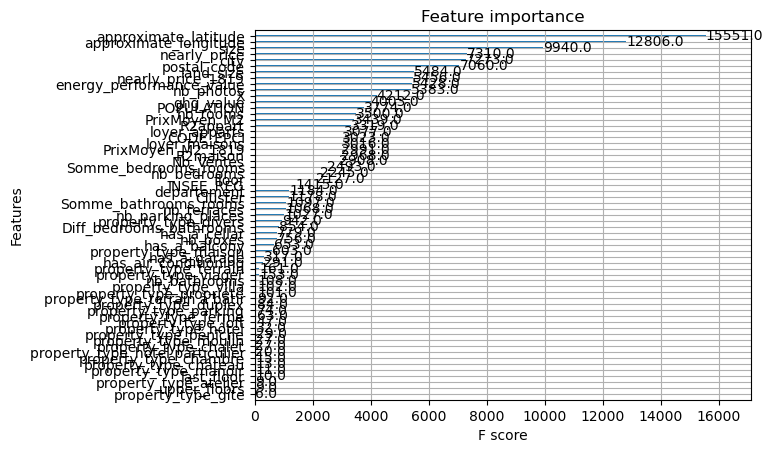

In [28]:
# Importance des features
xgb.plot_importance(xgb_best)
    